In [317]:
import pandas as pd
import ta
from ta.trend import EMAIndicator, macd, PSARIndicator
from ta.volatility import BollingerBands
from ta.momentum import rsi

def AddIndicators(df):
    
    df["ema5"] = EMAIndicator(close=df["close"], window=5, fillna=True).ema_indicator()
    df["ema8"] = EMAIndicator(close=df["close"], window=8, fillna=True).ema_indicator()
    df["ema13"] = EMAIndicator(close=df["close"], window=13, fillna=True).ema_indicator()

    df["MACD hist"] = ta.trend.macd_diff(close=df["close"], window_slow=26, window_fast=12, fillna=True)
    df["MACD signal"] = ta.trend.macd_signal(close=df["close"], window_slow=26, window_fast=12, fillna=True)
    df["MACD"] = macd(close=df["close"], window_slow=26, window_fast=12, fillna=True)

    df["RSI"] = rsi(close=df["close"], window=14, fillna=True)
    
    return df

In [318]:
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from datetime import datetime
import os
import cv2
import numpy as np

def Write_to_file(Date, net_worth, filename='{}.txt'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))):
    for i in net_worth: 
        Date += " {}".format(i)
    #print(Date)
    if not os.path.exists('logs'):
        os.makedirs('logs')
    file = open("logs/"+filename, 'a+')
    file.write(Date+"\n")
    file.close()

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range, Show_reward=False, Show_indicators=False):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        self.ax5 = plt.subplot2grid((8,1), (6,0), rowspan=1, colspan=1, sharex=self.ax1)
        self.ax6 = plt.subplot2grid((8,1), (7,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

        # define if show indicators
        if self.Show_indicators:
            self.Create_indicators_lists()

    def Create_indicators_lists(self):
        # Create a new axis for indicatorswhich shares its x-axis with volume
        self.ax4 = self.ax2.twinx()
        
        self.ema5 = deque(maxlen=self.Render_range)
        self.ema8 = deque(maxlen=self.Render_range)
        self.ema13 = deque(maxlen=self.Render_range)

        self.MACD = deque(maxlen=self.Render_range)
        self.MACD_signal = deque(maxlen=self.Render_range)
        self.MACD_hist = deque(maxlen=self.Render_range)
        
        self.RSI = deque(maxlen=self.Render_range)


    def Plot_indicators(self, df, Date_Render_range):
        self.ema5.append(df["ema5"])
        self.ema8.append(df["ema8"])
        self.ema13.append(df["ema13"])

        self.MACD.append(df["MACD"])
        self.MACD_signal.append(df["MACD signal"])
        self.MACD_hist.append(df["MACD hist"])
        self.RSI.append(df["RSI"])

        # Add Simple Moving Average
        #self.ax1.plot(Date_Render_range, self.ema5,'r-')
        #self.ax1.plot(Date_Render_range, self.ema8,'g-')
        #self.ax1.plot(Date_Render_range, self.ema13,'b-')

        self.ax4.clear()
        self.ax5.clear()
        self.ax6.clear()
        # # Add Moving Average Convergence Divergence
        self.ax5.plot(Date_Render_range, self.MACD,'r-')
        self.ax5.plot(Date_Render_range, self.MACD_signal,'b-')
        self.ax5.plot(Date_Render_range, self.MACD_hist,'g-')
        self.ax5.fill_between(Date_Render_range, 0, self.MACD_hist, where=(np.array(self.MACD_hist)-1) < -1 , color='red')
        self.ax5.fill_between(Date_Render_range, 0, self.MACD_hist, where=(np.array(self.MACD_hist)-1) > -1 , color='green')

        # # Add Relative Strength Index
        self.ax6.plot(Date_Render_range, self.RSI,'b-')

    # Render the environment to the screen
    #def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
    def render(self, df, net_worth, trades):
        Date = df["datetime"]
        Open = df["open"]
        High = df["high"]
        Low = df["low"]
        Close = df["close"]
        Volume = df["volume"]
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        Date = mpl_dates.date2num([pd.to_datetime(Date)])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0, color = 'gray')

        if self.Show_indicators:
            self.Plot_indicators(df, Date_Render_range)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="black")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        minimum = np.min(np.array(self.render_data)[:,1:])
        maximum = np.max(np.array(self.render_data)[:,1:])
        RANGE = maximum - minimum


        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['datetime'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['low'] - RANGE*0.02
                    ycoords = trade['low'] - RANGE*0.08
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['high'] + RANGE*0.02
                    ycoords = trade['high'] + RANGE*0.06
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

                if self.Show_reward:
                    try:
                        self.ax1.annotate('{0:.2f}'.format(trade['Reward']), (trade_date-0.02, high_low), xytext=(trade_date-0.02, ycoords),
                                                   bbox=dict(boxstyle='round', fc='w', ec='k', lw=1), fontsize="small")
                    except:
                        pass

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        #plt.show(block=False)
        # Necessary to view frames before they are unrendered
        #plt.pause(0.001)

        """Display image with OpenCV - no interruption"""

        # redraw the canvas
        self.fig.canvas.draw()
        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        
        # img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # display image with OpenCV or any operation you like
        cv2.imshow("Bitcoin trading bot",image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return
        else:
            return img
        

def Plot_OHCL(df):
    df_original = df.copy()
    # necessary convert to datetime
    df["datetime"] = pd.to_datetime(df.Date)
    df["datetime"] = df["date"].apply(mpl_dates.date2num)

    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
    
    # We are using the style ‘ggplot’
    plt.style.use('ggplot')
    
    # figsize attribute allows us to specify the width and height of a figure in unit inches
    fig = plt.figure(figsize=(16,8)) 

    # Create top subplot for price axis
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)

    # Create bottom subplot for volume which shares its x-axis
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
    ax5 = plt.subplot2grid((8,1), (6,0), rowspan=1, colspan=1, sharex=ax1)
    ax6 = plt.subplot2grid((8,1), (7,0), rowspan=1, colspan=1, sharex=ax1)

    candlestick_ohlc(ax1, df.values, width=0.8/24, colorup='green', colordown='red', alpha=0.8)
    ax1.set_ylabel('Price', fontsize=12)
    plt.xlabel('Date')
    plt.xticks(rotation=45)

    # Add Simple Moving Average
    ax1.plot(df["Date"], df_original['ema5'],'-')
    ax1.plot(df["Date"], df_original['ema8'],'-')
    ax1.plot(df["Date"], df_original['ema13'],'-')

    # # Add Moving Average Convergence Divergence
    ax5.plot(df["Date"], df_original['MACD'],'-')
    ax5.plot(df["Date"], df_original['MACD signal'],'-')
    ax5.fill_between(df["Date"], 0,df_original['MACD'], where=(df_original['MACD']-1) < -1 , color='red')
    ax5.fill_between(df["Date"], 0,df_original['MACD'], where=(df_original['MACD']-1) > -1 , color='green')

    # # Add Relative Strength Index
    ax6.plot(df["Date"], df_original['RSI'],'-')

    # beautify the x-labels (Our Date format)
    ax1.xaxis.set_major_formatter(mpl_dates.DateFormatter('%y-%m-%d'))# %H:%M:%S'))
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.show()

In [319]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass
    

class Shared_Model:
    def __init__(self, input_shape, action_space, lr, optimizer, model="Dense"):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Flatten()(X_input)
        X = Dense(512, activation="relu")(X)
        
        # Critic model
        V = Dense(512, activation="relu")(X)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

        # Actor model
        A = Dense(512, activation="relu")(X)
        A = Dense(256, activation="relu")(A)
        A = Dense(64, activation="relu")(A)
        output = Dense(self.action_space, activation="softmax")(A)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))

    def ppo_loss(self, y_true, y_pred):

        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])


class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Flatten(input_shape=input_shape)(X_input)
        X = Dense(512, activation="relu")(X)
        X = Dense(256, activation="relu")(X)
        X = Dense(64, activation="relu")(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))

    def ppo_loss(self, y_true, y_pred):
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)

        V = Flatten(input_shape=input_shape)(X_input)
        V = Dense(512, activation="relu")(V)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2)
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

In [320]:
import os
import copy
import pandas as pd
import numpy as np
import random
from collections import deque
from tensorboardX import SummaryWriter
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
import matplotlib.pyplot as plt
from datetime import datetime

class CustomAgent:
    def __init__(self, lookback_window_size=50, lr=0.00005, epochs=1, optimizer=Adam, batch_size=32, model=""):
        self.lookback_window_size = lookback_window_size
        self.model = model
        
        self.action_space = np.array([0, 1, 2])

        self.log_name = datetime.now().strftime("%Y_%m_%d_%H_%M")+"_trader"
        
        self.state_size = (lookback_window_size, 10+2)

        self.lr = lr
        self.epochs = epochs
        self.optimizer = optimizer
        self.batch_size = batch_size
        
        self.Actor = self.Critic = Shared_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer, model=self.model)
        
    def create_writer(self, initial_balance, normalize_value, train_episodes):
        self.replay_count = 0
        self.writer = SummaryWriter('runs/'+self.log_name)

        if not os.path.exists(self.log_name):
            os.makedirs(self.log_name)

        self.start_training_log(initial_balance, normalize_value, train_episodes)
            
    def start_training_log(self, initial_balance, normalize_value, train_episodes):
        with open(self.log_name+"/Parameters.txt", "w") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training start: {current_date}\n")
            params.write(f"initial_balance: {initial_balance}\n")
            params.write(f"training episodes: {train_episodes}\n")
            params.write(f"lookback_window_size: {self.lookback_window_size}\n")
            params.write(f"lr: {self.lr}\n")
            params.write(f"epochs: {self.epochs}\n")
            params.write(f"batch size: {self.batch_size}\n")
            params.write(f"normalize_value: {normalize_value}\n")
            params.write(f"model: {self.model}\n")
            
    def end_training_log(self):
        with open(self.log_name+"/Parameters.txt", "a+") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training end: {current_date}\n")

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.95, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        values = self.Critic.critic_predict(states)
        next_values = self.Critic.critic_predict(next_states)
        
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        y_true = np.hstack([advantages, predictions, actions])
        
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)
        c_loss = self.Critic.Critic.fit(states, target, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1

        return np.sum(a_loss.history['loss']), np.sum(c_loss.history['loss'])

    def act(self, state):
        prediction = self.Actor.actor_predict(np.expand_dims(state, axis=0))[0]
        action = np.random.choice(self.action_space, p=prediction)
        return action, prediction
        
    def save(self, name="trader", score="", args=[]):
        self.Actor.Actor.save_weights(f"{self.log_name}/{score}_{name}_Actor.h5")
        self.Critic.Critic.save_weights(f"{self.log_name}/{score}_{name}_Critic.h5")

        if len(args) > 0:
            with open(f"{self.log_name}/log.txt", "a+") as log:
                current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                atgumets = ""
                for arg in args:
                    atgumets += f", {arg}"
                log.write(f"{current_time}{atgumets}\n")

    def load(self, folder, name):
        self.Actor.Actor.load_weights(os.path.join(folder, f"{name}_Actor.h5"))
        self.Critic.Critic.load_weights(os.path.join(folder, f"{name}_Critic.h5"))

        
class CustomEnv:
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, Render_range=100, Show_reward=False, Show_indicators=False, normalize_value=40000):
        self.df = df.dropna().reset_index()[['datetime','open','high','low','close','volume','MACD','RSI']]
        self.df_graph = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        self.market_history = deque(maxlen=self.lookback_window_size)

        self.indicators_history = deque(maxlen=self.lookback_window_size)

        self.normalize_value = normalize_value

    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(Render_range=self.Render_range, Show_reward=self.Show_reward, Show_indicators=self.Show_indicators) # init visualization
        self.trades = deque(maxlen=self.Render_range)
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.held = 0
        self.sold = 0
        self.bought = 0
        self.episode_orders = 0
        self.prev_episode_orders = 0
        self.rewards = deque(maxlen=self.Render_range)
        self.env_steps_size = env_steps_size
        self.punish_value = 0
        if env_steps_size > 0:
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else:
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])

            self.market_history.append([self.df.loc[current_step, 'open'],
                                        self.df.loc[current_step, 'high'],
                                        self.df.loc[current_step, 'low'],
                                        self.df.loc[current_step, 'close'],
                                        self.df.loc[current_step, 'volume'],
                                        ])

            self.indicators_history.append([
                                        self.df.loc[current_step, 'MACD'] / 400,
                                        self.df.loc[current_step, 'RSI'] / 100
                                        ])
            

        state = np.concatenate((self.market_history, self.orders_history), axis=1) / self.normalize_value
        state = np.concatenate((state, self.indicators_history), axis=1)

        return state

    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'volume'],
                                    ])

        self.indicators_history.append([
                                    self.df.loc[self.current_step, 'MACD'] / 400,
                                    self.df.loc[self.current_step, 'RSI'] / 100
                                    ])
        
        obs = np.concatenate((self.market_history, self.orders_history), axis=1) / self.normalize_value
        obs = np.concatenate((obs, self.indicators_history), axis=1)
        
        return obs

    def step(self, action):
        self.bought = 0
        self.sold = 0
        self.current_step += 1

        current_price = self.df.loc[self.current_step, 'open']
        Date = self.df.loc[self.current_step, 'datetime']
        High = self.df.loc[self.current_step, 'high']
        Low = self.df.loc[self.current_step, 'low']

        if action == 0:
            pass

        elif action == 1 and self.balance > self.initial_balance/100:
            self.bought = self.balance / current_price
            self.balance -= self.bought * current_price
            self.held += self.bought
            self.trades.append({'datetime' : Date, 'high' : High, 'low' : Low, 'total': self.bought, 'type': "buy", 'current_price': current_price})
            self.episode_orders += 1

        elif action == 2 and self.held>0:
            self.sold = self.held
            self.balance += self.sold * current_price
            self.held -= self.sold
            self.trades.append({'datetime' : Date, 'high' : High, 'low' : Low, 'total': self.sold, 'type': "sell", 'current_price': current_price})
            self.episode_orders += 1

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])

        reward = self.get_reward()

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation()
        
        return obs, reward, done

    def get_reward(self):
        self.punish_value += self.net_worth * 0.00001
        if self.episode_orders > 1 and self.episode_orders > self.prev_episode_orders:
            self.prev_episode_orders = self.episode_orders
            if self.trades[-1]['type'] == "buy" and self.trades[-2]['type'] == "sell":
                reward = self.trades[-2]['total']*self.trades[-2]['current_price'] - self.trades[-2]['total']*self.trades[-1]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
            elif self.trades[-1]['type'] == "sell" and self.trades[-2]['type'] == "buy":
                reward = self.trades[-1]['total']*self.trades[-1]['current_price'] - self.trades[-2]['total']*self.trades[-2]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
        else:
            return 0 - self.punish_value

    def render(self, visualize = False):
        if visualize:
            img = self.visualization.render(self.df_graph.loc[self.current_step], self.net_worth, self.trades)
            return img

def train_agent(env, agent, visualize=False, train_episodes = 50, training_batch_size=500):
    agent.create_writer(env.initial_balance, env.normalize_value, train_episodes)
    total_average = deque(maxlen=100)
    best_average = 0
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)

        states, actions, rewards, predictions, dones, next_states = [], [], [], [], [], []
        for t in range(training_batch_size):
            env.render(visualize)
            action, prediction = agent.act(state)
            next_state, reward, done = env.step(action)
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            action_onehot = np.zeros(3)
            action_onehot[action] = 1
            actions.append(action_onehot)
            rewards.append(reward)
            dones.append(done)
            predictions.append(prediction)
            state = next_state

        a_loss, c_loss = agent.replay(states, actions, rewards, predictions, dones, next_states)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        
        agent.writer.add_scalar('Data/average net_worth', average, episode)
        agent.writer.add_scalar('Data/episode_orders', env.episode_orders, episode)
        
        print("episode: {:<5} net worth {:<7.2f} average: {:<7.2f} orders: {}".format(episode, env.net_worth, average, env.episode_orders))
        if episode > len(total_average):
            if best_average < average:
                best_average = average
                print("Saving model")
                agent.save(score="{:.2f}".format(best_average), args=[episode, average, env.episode_orders, a_loss, c_loss])
            agent.save()
            
    agent.end_training_log()
    
def test_agent(env, agent, visualize=True, test_episodes=10, folder="", name="_trader", comment=""):
    agent.load(folder, name)
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action, prediction = agent.act(state)
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1
                print("episode: {:<5}, net_worth: {:<7.2f}, average_net_worth: {:<7.2f}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break
            
    print("average {} episodes agent net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    print("No profit episodes: {}".format(no_profit_episodes))
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {name}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, model: {agent.model}, comment: {comment}\n')




In [228]:
ddf = pd.read_csv('pfedata.csv')[['datetime','open','high','low','close','volume','ema5','ema8','ema13','MACD','RSI']]

In [229]:
AddIndicators(ddf)

,datetime,open,high,low,close,volume,ema5,ema8,ema13,MACD,RSI,MACD hist,MACD signal
0,2020-01-02 17:30:00,37.235397,37.292274,36.875177,36.988931,264176.0,36.988931,36.988931,36.988931,0.000000,100.000000,0.000000,0.000000
1,2020-01-02 18:30:00,36.988931,37.050548,36.894136,36.936794,113237.0,36.971552,36.977345,36.981483,-0.004159,0.000000,-0.003327,-0.000832
2,2020-01-02 19:30:00,36.932054,36.951013,36.894136,36.946273,75932.0,36.963126,36.970440,36.976453,-0.006614,16.373612,-0.004626,-0.001988
3,2020-01-02 20:30:00,36.946273,36.951013,36.884657,36.894136,48912.0,36.940129,36.953484,36.964693,-0.012621,8.312035,-0.008506,-0.004115
4,2020-01-02 21:30:00,36.903616,36.913095,36.860958,36.879917,55462.0,36.920058,36.937135,36.952582,-0.018318,7.261924,-0.011363,-0.006955
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850,2023-04-28 20:30:00,38.865000,38.880000,38.700000,38.770000,302146.0,38.773945,38.743905,38.747369,-0.194387,43.459267,0.085961,-0.280349
5851,2023-04-28 21:30:00,38.770000,38.800000,38.705000,38.760000,212364.0,38.769297,38.747481,38.749173,-0.178510,43.152600,0.081471,-0.259981
5852,2023-04-28 22:30:00,38.760000,38.910000,38.710000,38.900000,492133.0,38.812865,38.781374,38.770720,-0.152869,48.618985,0.085690,-0.238559
5853,2023-05-01 16:30:00,39.010000,39.200000,38.870000,39.140000,496579.0,38.921910,38.861069,38.823474,-0.111892,56.365215,0.101333,-0.213225


In [230]:
load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [231]:
reload_ext tensorboard

In [17]:
tensorboard --logdir=runs/ --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 14256), started 1 day, 3:46:05 ago. (Use '!kill 14256' to kill it.)

In [321]:
lookback_window_size = 50
test_window = 805
train_df = ddf[:-test_window-lookback_window_size]
test_df = ddf[-test_window-lookback_window_size:]
agent = CustomAgent(lookback_window_size=lookback_window_size, lr=0.00001, epochs=5, optimizer=Adam, batch_size = 32, model="Dense")

C:\Users\ThinkPadX4\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [322]:
test_df['datetime'] = pd.date_range(start = "2022-11-21 18:30:00", periods = 855, freq='H')

C:\Users\ThinkPadX4\AppData\Local\Temp\ipykernel_15292\1364660045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['datetime'] = pd.date_range(start = "2022-11-21 18:30:00", periods = 855, freq='H')


In [323]:
test_df = test_df.iloc[:350]

In [324]:
test_df

,datetime,open,high,low,close,volume,ema5,ema8,ema13,MACD,RSI,MACD hist,MACD signal
5000,2022-11-21 18:30:00,48.010,48.080,47.855,48.010,164095.0,47.874715,47.732564,47.535662,0.456151,67.239274,0.043503,0.412648
5001,2022-11-21 19:30:00,47.810,48.090,47.220,47.310,173494.0,47.686477,47.638661,47.503425,0.401467,53.323618,-0.008944,0.410412
5002,2022-11-21 20:30:00,47.320,47.445,47.195,47.350,95036.0,47.574318,47.574514,47.481507,0.357240,53.910604,-0.042537,0.399777
5003,2022-11-21 21:30:00,47.340,47.410,47.045,47.045,50356.0,47.397878,47.456844,47.419149,0.294187,48.864575,-0.084472,0.378659
5004,2022-11-21 22:30:00,47.045,47.270,46.960,47.230,75199.0,47.341919,47.406434,47.392127,0.256192,51.810902,-0.097974,0.354166
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5345,2022-12-06 03:30:00,48.010,48.010,47.860,47.910,44387.0,47.869966,47.782080,47.717245,-0.193203,49.365265,0.175962,-0.369166
5346,2022-12-06 04:30:00,47.910,48.025,47.850,47.890,47858.0,47.876644,47.806062,47.741924,-0.165421,48.941638,0.162995,-0.328417
5347,2022-12-06 05:30:00,47.885,48.020,47.800,47.870,127696.0,47.874430,47.820270,47.760221,-0.143365,48.493482,0.148042,-0.291406
5348,2022-12-06 06:30:00,47.865,47.980,47.805,47.850,95091.0,47.866286,47.826877,47.773046,-0.126046,48.019941,0.132288,-0.258334


C:\Users\ThinkPadX4\anaconda3\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode: 0     net worth 1053.00 average: 1053.00 orders: 70


KeyboardInterrupt: 

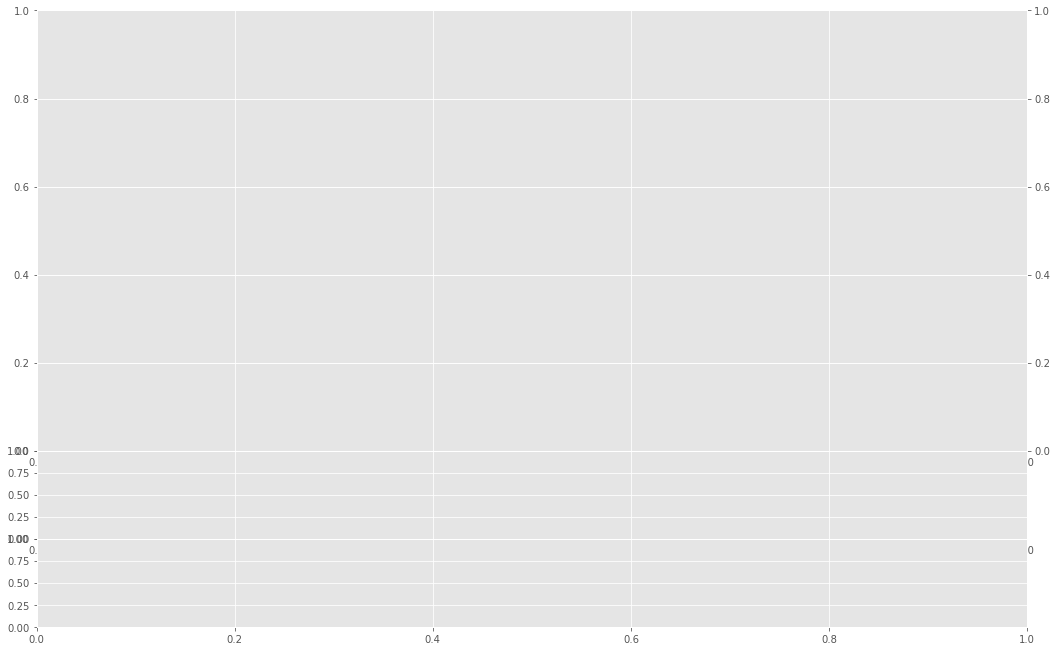

In [55]:
train_env = CustomEnv(train_df, lookback_window_size=lookback_window_size)
train_agent(train_env, agent, visualize=False, train_episodes=20000, training_batch_size=500)

C:\Users\ThinkPadX4\AppData\Local\Temp\ipykernel_15292\2169220456.py:185: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


episode: 0    , net_worth: 967.40 , average_net_worth: 967.40 , orders: 127
average 1 episodes agent net_worth: 967.4041179957609, orders: 127.0
No profit episodes: 1


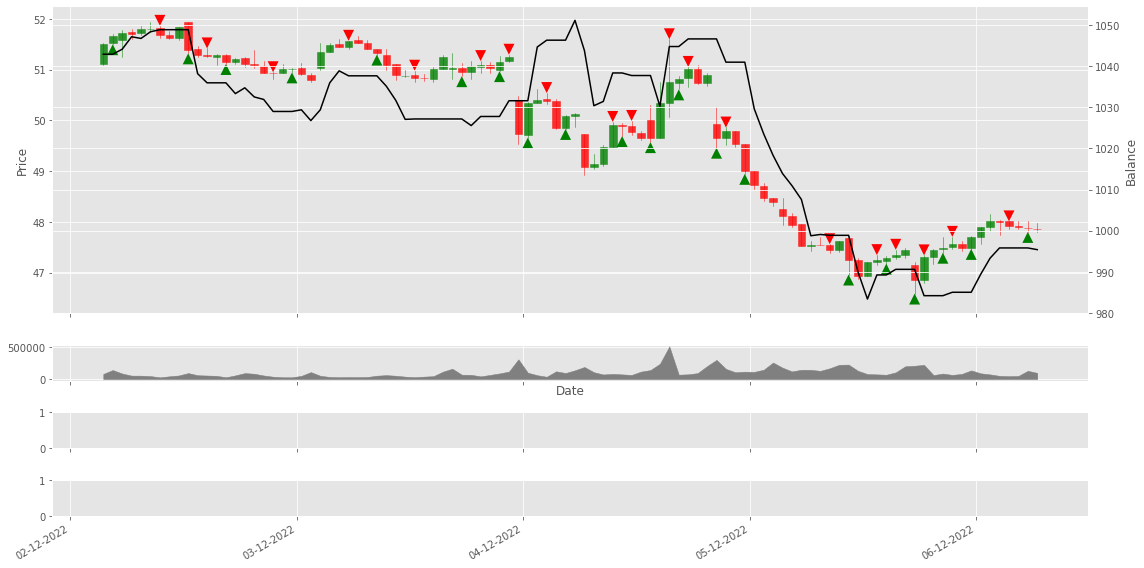

In [326]:
test_env = CustomEnv(test_df, lookback_window_size=lookback_window_size, Show_reward=False, Show_indicators=False)
test_agent(test_env, agent, visualize=True, test_episodes=1, folder="Medium", name="2557.22_trader", comment="")

In [257]:
np.array(deque([1]))

array([1])